In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.visualization import plot_bloch_vector, plot_histogram
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setting up registers and circuits
# One qubit per gate tested
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(0, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

### Quantum Fourier Transform

The Quantum Fourier Transform is useful in a myriad of situations, including Shor's algorithm. It encodes the value of a binary number j of length n, into the phase of each qubit representing it's individual parts.

The QFT can be represented by the following identity:

$$
|j\rangle \rightarrow {\frac{1}{\sqrt{2^n}}} {\sum_{k=0}^{2^n-1}} e^\frac{2\pi ijk}{2^n} |k\rangle
$$

Which deviates from its classical formula, though this is intended as we are focussing on the quantum implementation.

- Introduce R gate(s)

We will be using 3 different gates:

### The Hadamard gate:

$$
H = \frac{1}{\sqrt{2}} \begin{bmatrix} 1&1 \\\ 1&-1 \end{bmatrix}
$$
(Please refer to the single_qubit_gates notebook for more info on the H gate)
### The R gate:

The matrix representation of the R Gate is:
$$
R_{k}  = \begin{bmatrix} 1&0 \\\ 0&e^{\frac{2\pi i}{2^{k}}}  \end{bmatrix}
$$

The R gate contains a variable k, which affects the phase of the qubit.
It is a controlled gate, which means it only acts if the control is a 1

$$
R_{k}|0\rangle \rightarrow |0\rangle
$$
$$
R_{k}|1\rangle \rightarrow e^{\frac{2\pi i}{2^{k}}}|1\rangle
$$

### The Swap gate:

The Swap gate swaps two qubits.

### Logic

We will use 3 qubits for our binary number j of length n:
$$(j_1, j_2, ...j_n)$$
The binary representation would therefore look as follows:
$$(j_1 2^{n-1}, j_2 2^{n-2}, ...j_n 2^0)$$

First, we apply the Hadamard Gate to the first qubit to put it in superposition:

$$
H|j_0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + (-1)^{j_0}|1\rangle)
$$

We can then represent it as follows, with the -1 being turned into polar form using eulers identity:

$$
H|j_0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + e^{i \pi j_0}|1\rangle)
$$

We then turn $j_0$ into a fraction to accomodate the binary representation:
$$
H|j_0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i(\frac{j_0}{2})}|1\rangle)
$$

Next, we apply the first R gate, $R_2$. Note that $j_1$ is the control gate, so we can express its added relative phase as $\left(e^{\frac{2\pi i}{2^2}}\right)^{j_1}$ as we simply don't apply the phase if $j_1$ is 0. We can simplify this to:
$$
R_2H|j_0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i(\frac{j_0}{2})} e^{2\pi i(\frac{j_1}{4})}|1\rangle)
$$

Which is equal to:

$$
R_2H|j_0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i(\frac{j_0}{2} + \frac{j_1}{4})}|1\rangle)
$$

Doing the Same for the R3 Gate, we get:

$$
R_2H|j_0\rangle \rightarrow \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i(\frac{j_0}{2} + \frac{j_1}{4} + \frac{j_2}{8})}|1\rangle)
$$

We then apply the same logic to the other qubits, with $j_1$ having a hadamard and $R_2$ gate applied, and $J_2$ only having a hadamard gate applied:

$$
|\psi\rangle = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i(\frac{j_0}{2} + \frac{j_1}{4} + \frac{j_2}{8})}|1\rangle)\;(|0\rangle + e^{2\pi i(\frac{j_1}{2} + \frac{j_2}{4})}|1\rangle)\;(|0\rangle + e^{2\pi i(\frac{j_2}{2})}|1\rangle)
$$

The final step is to apply a swap gate to qubits $j_0$ and $j_2$, giving us the product state:

$$
QFT = \frac{1}{\sqrt{2}}(|0\rangle + e^{2\pi i(\frac{j_2}{2})}|1\rangle)\;(|0\rangle + e^{2\pi i(\frac{j_1}{2} + \frac{j_2}{4})}|1\rangle)\;(|0\rangle + e^{2\pi i(\frac{j_0}{2} + \frac{j_1}{4} + \frac{j_2}{8})}|1\rangle)
$$

We have now encoded the value of j into the phase of the qubits.

To prove that our maths is right, lets try to run this circuit with the binary number:

$$|j\rangle = |3\rangle = |011\rangle
$$


## Manual Implementation

This is a manual implementation of the QFT to showcase our logic in code

        ┌───┐┌───┐                                         ░ ┌─┐      
   q_0: ┤ X ├┤ H ├─■────────■───────────────────────────X──░─┤M├──────
        ├───┤└───┘ │P(π/2)  │       ┌───┐               │  ░ └╥┘┌─┐   
   q_1: ┤ X ├──────■────────┼───────┤ H ├─■─────────────┼──░──╫─┤M├───
        └───┘               │P(π/4) └───┘ │P(π/2) ┌───┐ │  ░  ║ └╥┘┌─┐
   q_2: ────────────────────■─────────────■───────┤ H ├─X──░──╫──╫─┤M├
                                                  └───┘    ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════════════════════════╩══╩══╩═
                                                              0  1  2 


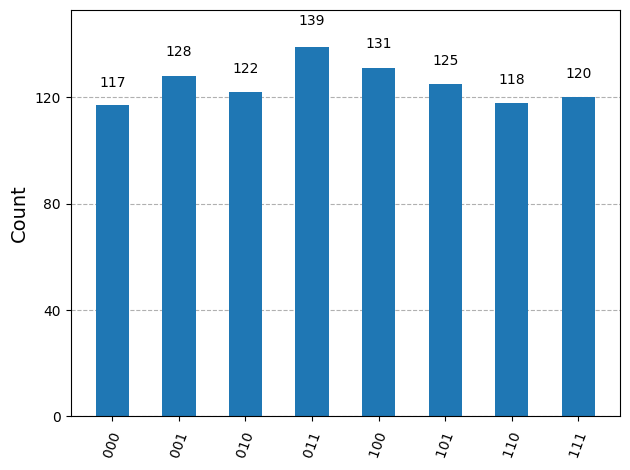

In [3]:
def manual_qft(circuit: QuantumCircuit, qubits, do_swaps=True):
    circuit.x(0)
    circuit.x(1)
    n = len(qubits)
    for j in range(n):
        circuit.h(qubits[j])
        for m in range(j+1, n):
            # angle = 2π / 2^{(m-j+1)}  ==  π / 2^{(m-j)}
            theta = np.pi / (2**(m - j))
            circuit.cp(theta, qubits[m], qubits[j])

    if do_swaps:
        # reverse order to match the canonical QFT output bit order
        for i in range(n//2):
            circuit.swap(qubits[i], qubits[n-1-i])

    circuit.measure_all()
    return circuit

# Simulation:
circuit = manual_qft(circuit, qreg_q)
print(circuit)
result = AerSimulator().run(circuit, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)

## QFT Method Implementation

This version uses the qft() method built into qiskit, much easier and cleaner.

     ┌───┐┌──────┐
q_0: ┤ X ├┤0     ├
     ├───┤│      │
q_1: ┤ X ├┤1 QFT ├
     └───┘│      │
q_2: ─────┤2     ├
          └──────┘


/var/folders/hs/7sx42v1x0fx_c6wkjrzgzy500000gn/T/ipykernel_46206/4135278606.py:5: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_qubits=3, do_swaps=True, approximation_degree=0).decompose(), [0,1,2])


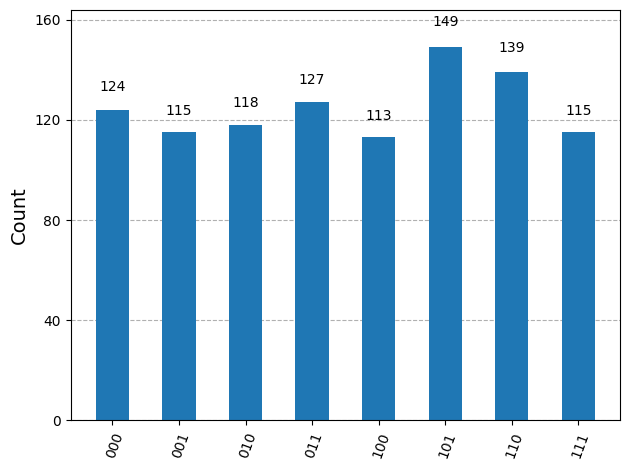

In [4]:
n = 3
qc = QuantumCircuit(n)
qc.x(0)
qc.x(1)
qc.append(QFT(num_qubits=3, do_swaps=True, approximation_degree=0).decompose(), [0,1,2])
print(qc)

qc.measure_all()

# result = AerSimulator().run(qc, shots=100).result()
# counts = result.get_counts()
# print(counts)

sim = AerSimulator()
tqc = transpile(qc, sim)
result = sim.run(tqc, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)